Train classifier of primary endpoint type in EUCT-NS dataset using CNB with TF-IDF Features

In [1]:
import pandas as pd

import numpy as np 
from numpy import mean, std

from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import ComplementNB 
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, classification_report, balanced_accuracy_score
import joblib

import nltk

import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
import tqdm as notebook_tqdm

import joblib

Train the classifier

In [2]:
euct_ns = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\euct_ns.csv', encoding='unicode_escape')

In [3]:
euct_ns['concat_corpus'] = euct_ns['Title']+ " " + euct_ns['Objective'] + " " + euct_ns['pr_endpoint'] + " " + euct_ns['endpoint_description']

In [4]:
euct_ns['concat_corpus'] = euct_ns['concat_corpus'].fillna('')

In [5]:
vectorizer = TfidfVectorizer(analyzer='word', min_df=10, ngram_range=(1,3))
tfidf_matrix = vectorizer.fit_transform(euct_ns['concat_corpus'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [6]:
X = tfidf_df
y = euct_ns['manual_label'].values

In [7]:
joblib.dump(vectorizer, "tf_idf embeddings.pkl")

['tf_idf embeddings.pkl']

In [8]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [10]:
cnb = ComplementNB(alpha = 1.0, fit_prior = True)

In [11]:
# Train the model on the training data
cnb.fit(X_train, y_train)

# Make predictions on the test data
y_pred = cnb.predict(X_test)

In [12]:
joblib.dump(cnb, "model.pkl")

['model.pkl']

In [ ]:
print(y_test)

In [ ]:
print(y_pred) # There is no cases of intermediate outcomes in the pred set. Do I re-run it?

In [13]:
accuracy_balanced = balanced_accuracy_score(y_test, y_pred)
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

# Get the predicted probabilities
y_pred_proba = cnb.predict_proba(X_test)

# Calculate AUROC score using predicted probabilities
auroc_weighted = roc_auc_score(y_test, y_pred_proba, average='weighted', multi_class='ovr')

accuracy_weighted = accuracy_score(y_test, y_pred)
classification_metrics = classification_report(y_test, y_pred, output_dict=True)

#Print metrics
print(f'Precision (Weighted): {precision_weighted:.2f}, Mean={np.mean(precision_weighted):.2f}, Std={np.std(precision_weighted):.2f}')
print(f'Recall (Weighted): {recall_weighted:.2f}, Mean={np.mean(recall_weighted):.2f}, Std={np.std(recall_weighted):.2f}')
print(f'F1 Score (Weighted): {f1_weighted:.2f}, Mean={np.mean(f1_weighted):.2f}, Std={np.std(f1_weighted):.2f}')
print(f'AUROC (Weighted): {auroc_weighted:.2f}, Mean={np.mean(auroc_weighted):.2f}, Std={np.std(auroc_weighted):.2f}')
print()

print(f'Accuracy (Weighted): {accuracy_weighted:.2f}, Mean={np.mean(accuracy_weighted):.2f}, Std={np.std(accuracy_weighted):.2f}')
print("Precision, Recall, and F1 Score by Class:")
for cls, metrics in classification_metrics.items():
    if cls.isdigit():  # Filter class-specific metrics
        print(f"  Class {cls}: Precision={metrics['precision']:.2f}, Recall={metrics['recall']:.2f}, F1 Score={metrics['f1-score']:.2f}")

Precision (Weighted): 0.71, Mean=0.71, Std=0.00
Recall (Weighted): 0.58, Mean=0.58, Std=0.00
F1 Score (Weighted): 0.61, Mean=0.61, Std=0.00
AUROC (Weighted): 0.75, Mean=0.75, Std=0.00

Accuracy (Weighted): 0.58, Mean=0.58, Std=0.00
Precision, Recall, and F1 Score by Class:
  Class 0: Precision=0.82, Recall=0.54, F1 Score=0.65
  Class 1: Precision=0.20, Recall=0.67, F1 Score=0.31
  Class 2: Precision=0.55, Recall=0.67, F1 Score=0.60


In [14]:
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_test, y_pred, target_names=target_names))

              precision    recall  f1-score   support

     class 0       0.82      0.54      0.65        26
     class 1       0.20      0.67      0.31         3
     class 2       0.55      0.67      0.60         9

    accuracy                           0.58        38
   macro avg       0.52      0.62      0.52        38
weighted avg       0.71      0.58      0.61        38



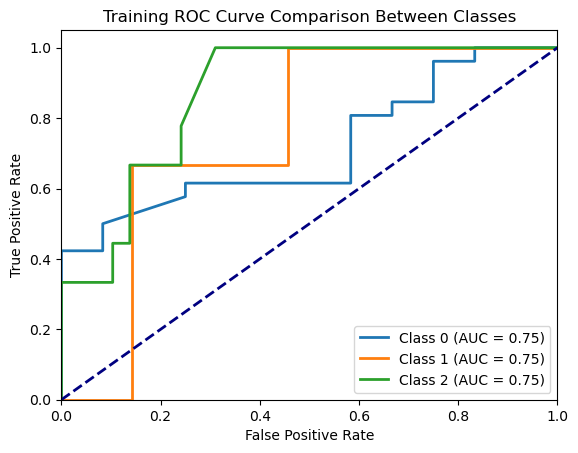

In [15]:
from sklearn.metrics import roc_curve

# Calculate the AUC - ROC score
roc_auc = roc_auc_score(y_test, y_pred_proba, average = 'weighted', multi_class='ovr')

# Compute ROC curve for each class
for i in range(cnb.classes_.shape[0]):
	fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, i], pos_label=i)
	plt.plot(fpr, tpr, lw=2, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot the diagonal 50% line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Customize the plot
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Training ROC Curve Comparison Between Classes')
plt.legend(loc="lower right")
plt.show()

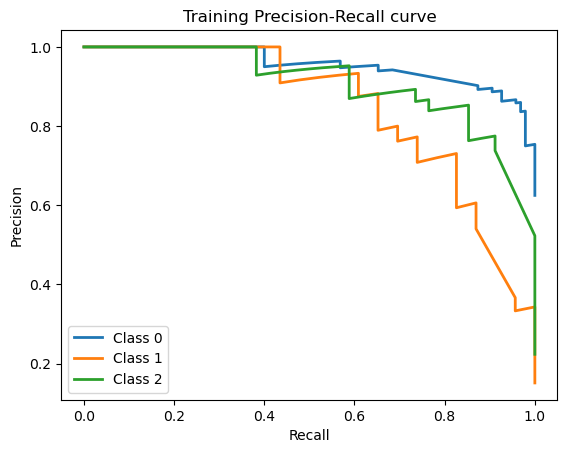

In [16]:
from sklearn.metrics import precision_recall_curve

# Compute precision-recall curve for each class
for i in range(cnb.classes_.shape[0]):
	y_prob_train = cnb.predict_proba(X_train)[:, i]
	y_prob_test = cnb.predict_proba(X_test)[:, i]

	precision, recall, thresholds = precision_recall_curve(y_train == i, y_prob_train)
	plt.plot(recall, precision, lw=2, label=f'Class {i}')

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Training Precision-Recall curve")
plt.legend(loc="best")
plt.show()

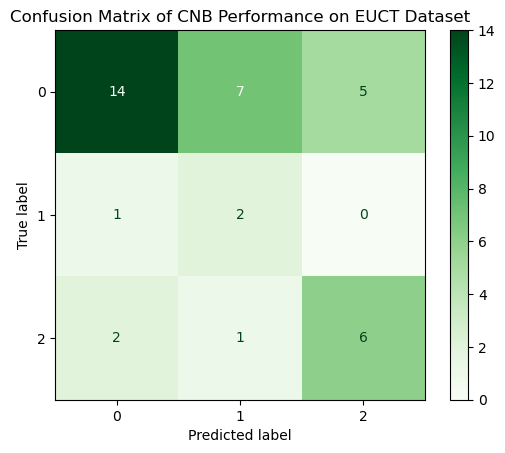

In [17]:
conf_matrix = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=cnb.classes_)
disp.plot(cmap=plt.cm.Greens)
plt.title('Confusion Matrix of CNB Performance on EUCT Dataset')
plt.show()

Apply CNB model to NS-HRA dataset

In [17]:
ns_hra = pd.read_csv('c:\\Users\\s2421127\\Documents\\NLP Project\\ObuayaO\\NLP project\\Chapter 3\\ns_hra.csv', encoding='unicode_escape')

In [18]:
display(ns_hra)
# Did not clean long-term follow up because it is not included in the feature set.

,Unique_ID,Title,Phase,Objective,End_date,Sample_size,1ry_endpoint,Treatment,LT_followup
0,IRAS_projectID_57754,phase ii multicenter randomized adaptive doubl...,ii,ass efficacy safety liquid suspension formulat...,31/05/2013 00:00,150.0,outcome measure motor function measure mfm d1 ...,NaN,Subjects will participate in the study for a t...
1,IRAS_projectID_82035,randomized controlled long term safety study e...,0,principal objective study ass long term safety...,30/09/2013 00:00,450.0,endpoint study change baseline total score nor...,NaN,Subjects will be involved in this study for ju...
2,IRAS_projectID_64187,randomized double blind double dummy parallel ...,0,ass whether efficacy ocrelizumab given two dos...,31/03/2015 00:00,800.0,efficacy analysis trial compare annualized pro...,NaN,Screening 2 weeks\nTreatment phase 96 weeks\nS...
3,IRAS_projectID_72673,multi centre open label randomised trial inves...,0,evaluate pharmacokinetics pk two different bat...,15/10/2011 00:00,10.0,endpoint pharmacokinetic endpoint pk endpoint ...,NaN,The subjects participation in the trial is exp...
4,IRAS_projectID_67978,use carer assisted adherence therapy people pa...,0,primary aim investigate seven week programme c...,NaN,120.0,outcome measure study morisky medication asses...,NaN,Three to three and a half months for patients ...
...,...,...,...,...,...,...,...,...,...
689,IRAS_projectID_289577,safety tolerability pharmacokinetics pharmacod...,0,primary objective trial compare safety tolerab...,21/10/2021 00:00,36.0,safety tolerability bi 1323495 assessed based ...,NaN,The Screening period of the study is 2-4 weeks...
690,IRAS_projectID_285292,phase 3 randomized double blind efficacy safet...,3,principal objective determine efficacy daily s...,27/09/2023 00:00,900.0,annualized adjudicated relapse rate number con...,NaN,The duration of the treatment period will vary...
691,IRAS_projectID_275551,phase 3 multicenter randomized double blind pl...,3,demonstrate superior efficacy treatment pf 069...,30/07/2027 00:00,99.0,change baseline week 52 north star ambulatory ...,NaN,Participants in Cohort 1 will be in the study ...
692,IRAS_projectID_290294,two part seamless multi center randomized plac...,0,primary objective study follows part 1 evaluat...,01/09/2023 00:00,231.0,endpoint part 2 change baseline total mfm 32 s...,NaN,The participant will be in the study for appro...


In [19]:
ns_hra['concat_corpus'] = ns_hra['Title']+ " " + ns_hra['Objective'] + " " + ns_hra['1ry_endpoint'] 

In [20]:
ns_hra['concat_corpus'] = ns_hra['concat_corpus'].fillna('')

In [21]:
print(ns_hra['concat_corpus'].head())

0    phase ii multicenter randomized adaptive doubl...
1    randomized controlled long term safety study e...
2    randomized double blind double dummy parallel ...
3    multi centre open label randomised trial inves...
4    use carer assisted adherence therapy people pa...
Name: concat_corpus, dtype: object


In [21]:
vectorizer = joblib.load("tf_idf embeddings.pkl")

In [ ]:
print(type(vectorizer))

In [22]:
X2 = vectorizer.transform(ns_hra['concat_corpus'])

In [23]:
model = joblib.load('model.pkl')

In [24]:
model.predict(X2)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but ComplementNB was fitted with feature names
  warnings.warn(


array([1, 0, 2, 2, 2, 2, 1, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2, 2, 2, 2, 0,
       2, 0, 2, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 0, 2, 2, 1, 0, 0, 2, 1, 2,
       0, 0, 2, 0, 2, 0, 1, 2, 1, 0, 0, 2, 1, 1, 2, 0, 1, 0, 1, 1, 2, 2,
       1, 2, 0, 1, 0, 1, 0, 1, 2, 1, 0, 0, 0, 2, 1, 0, 1, 1, 2, 2, 1, 2,
       1, 0, 1, 0, 2, 1, 2, 2, 1, 0, 1, 2, 0, 1, 0, 2, 0, 1, 0, 2, 1, 1,
       1, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 1, 0, 0, 0, 2,
       0, 2, 2, 0, 1, 0, 2, 2, 0, 2, 0, 1, 1, 0, 2, 0, 2, 2, 2, 0, 0, 1,
       2, 1, 1, 2, 0, 2, 1, 1, 2, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 1, 2, 1,
       0, 1, 1, 0, 2, 1, 2, 0, 2, 2, 0, 0, 1, 2, 0, 0, 2, 2, 0, 0, 0, 0,
       2, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 0, 1, 2, 0, 1, 1, 2,
       0, 1, 1, 2, 1, 0, 2, 2, 1, 2, 2, 1, 2, 1, 1, 0, 2, 0, 0, 1, 2, 0,
       0, 2, 2, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2,
       1, 0, 2, 1, 2, 0, 1, 0, 0, 2, 0, 1, 1, 2, 0, 2, 1, 0, 0, 1, 0, 2,
       2, 2, 2, 2, 1, 2, 0, 2, 0, 2, 0, 1, 0, 0, 2,

In [25]:
y_pred = model.predict(X2)

In [26]:
feature_names = vectorizer.get_feature_names_out()
X2_df = pd.DataFrame(X2.toarray(), columns=feature_names)

In [27]:
y_pred = model.predict(X2_df)
# To fix the warning above

In [35]:
unique, counts = np.unique(y_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 264, 1: 196, 2: 234}


In [36]:
confidences = model.predict_proba(X2_df).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.41


In [37]:
surrogate_confidence_class_2 = model.predict_proba(X2_df.iloc[[2]])[0][2]
print(f"Confidence for predicting class 2: {surrogate_confidence_class_2:.2f}")

Confidence for predicting class 2: 0.42


In [38]:
low_confidence_indices = np.where(confidences < 0.6)[0]
print(f"Low confidence predictions: {len(low_confidence_indices)}")

Low confidence predictions: 679


Active learning

1. Least confidence sampling

In [28]:
# Define the unlabeled dataset
X2_unlabeled = X2_df.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y_initial = manually_label_samples(X_initial_raw)
X_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_171682
Preprocessed Text: phase 3 randomized double blind study adjuvant immunotherapy nivolumab versus ipilimumab complete resection stage iiib c stage iv melanoma subject high risk recurrence pharmacogenetics blood sample amendment 01 site specific dated 03 dec 2014 compare efficacy measured recurrence free survival rf provided nivolumab versus ipilimumab subject completely resected stage iiib c stage iv ned melanoma high risk recurrence recurrence free survival

Unique_ID: IRAS_projectID_214032
Preprocessed Text: phase 3 multicenter randomized double blind extension study evaluate safety daily oral dosing tafamidis meglumine pf 06291826 20 mg 80 mg subject diagnosed transthyretin cardiomyopathy ttr cm AA obtain additional long term safety data tafamidis subject transthyretin amyloid cardiomyopathy ttr cm AA provide investigational product tafamidis ttr cm subject complete 30 month blinded treatment protocol b3461028 safety measured AA cause mortality AA inc

In [29]:
# Ensure X_train is always a list before extending
if 'X_train' not in locals() or not isinstance(X_train, list):
    X_train = list(X_initial)  # Convert to list explicitly
    y_train = np.array(y_initial)
else:
    X_train.extend(X_initial)
    y_train = np.hstack([y_train, y_initial])

# Remove labeled samples from unlabeled pool
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [30]:
print(len(X_train), len(y_train), X2_unlabeled_reset.shape)

7 7 (687, 353)


Determine best classifiers using grid search

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# Define parameter grids for different classifiers
param_grids = {
    'ComplementNB': {
        'model': [ComplementNB()],
        'model__alpha': [0.1, 0.5, 1],
        'model__fit_prior': [True, False],
    },
    'SVM': {
        'model': [SVC(probability=True)],
        'model__C': [0.1, 1, 10],
        'model__kernel': ['linear', 'rbf'],
    },
    'RandomForest': {
        'model': [RandomForestClassifier()],
        'model__n_estimators': [50, 100, 200],
        'model__max_depth': [None, 10, 20],
    },
    'MLP': {
        'model': [MLPClassifier(max_iter=500)],
        'model__hidden_layer_sizes': [(5,), (10,), (5, 5)],
        'model__activation': ['relu', 'tanh'],
    }
}

# Define a preprocessing pipeline (e.g., scaling if needed)
pipeline = Pipeline([
    ('scaler', StandardScaler(with_mean=False)),  # For sparse matrices, set `with_mean=False`
    ('model', ComplementNB())  # Placeholder for the classifier
])

# Reset the indices of X2_unlabeled and most_uncertain_indices
X2_unlabeled_reset = X2_unlabeled.reset_index(drop=True)
most_uncertain_indices_reset = most_uncertain_indices % len(X2_unlabeled_reset)

# Extract initial labeled data
X_initial = X2_unlabeled_reset.iloc[most_uncertain_indices_reset]
y_initial = y_initial

# Iterate over classifiers and parameter grids
best_models = {}
for name, param_grid in param_grids.items():
    print(f"Training {name}...")
    grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall_weighted', n_jobs=-1)
    grid.fit(X_initial, y_initial)
    best_models[name] = grid.best_estimator_
    print(f"Best {name} model: {grid.best_params_}")

# Choose the best classifier based on cross-validation scores
best_classifier_name = max(best_models, key=lambda x: best_models[x].score(X_initial, y_initial))
best_model = best_models[best_classifier_name]

print(f"Best overall classifier: {best_classifier_name}")

In [ ]:
Train the classifier

In [31]:
pipeline = make_pipeline(
    TfidfVectorizer(analyzer='word', min_df=3, ngram_range=(1, 3)),
    ComplementNB(alpha=0.1, fit_prior=True)
)

In [32]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [33]:
y_pred = pipeline.predict(X2_unlabeled_reset)

In [34]:
from sklearn.model_selection import cross_val_predict

y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=3)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=3.
  warnings.warn(


In [35]:
iter1 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter1)

{'0': {'precision': 0.8, 'recall': 1.0, 'f1-score': 0.8888888888888888, 'support': 4.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 1.0}, '2': {'precision': 1.0, 'recall': 1.0, 'f1-score': 1.0, 'support': 2.0}, 'accuracy': 0.8571428571428571, 'macro avg': {'precision': 0.6, 'recall': 0.6666666666666666, 'f1-score': 0.6296296296296297, 'support': 7.0}, 'weighted avg': {'precision': 0.7428571428571429, 'recall': 0.8571428571428571, 'f1-score': 0.7936507936507936, 'support': 7.0}}


c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

Iteration 2

In [36]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1) # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y2_initial = manually_label_samples(X_initial_raw)
X2_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_234065
Preprocessed Text: multicenter randomized double blind placebo controlled study subject relapsing multiple sclerosis evaluate efficacy safety biib033 add therapy anti inflammatory disease modifying therapy affinity evaluate effectiveness safety biib033 used add therapy disease modifying therapy dmts subject relapsing multiple sclerosis rms overall response score overall response score multicomponent score based 4 component expanded disability status scale eds timed 25 foot walk t25fw 9 hole peg test dominant hand 9hpt nondominant hand 9hptnd ass overall change disability time overall score range 4 visit component given score relative baseline 1 threshold met worsening 0 change meet threshold criterion 1 threshold met improvement threshold t25fw 9hpt defined 15 change baseline AA 15 decrease baseline improvement AA 15 increase baseline worsening eds improvement defined AA 1 0 point decrease eds baseline score AA 6 0 worsening defined AA 1 point increase 

In [37]:
X2_initial = list(X2_initial)
y_train = np.array(y2_initial)

In [38]:
print(len(X2_initial))

7


In [39]:
print(len(X_train))

7


In [40]:
X_train = X_train + X2_initial
y_train = np.hstack([y_initial, y2_initial])
len(X_train), len(y_train)

(14, 14)

In [41]:
# Remove labelled samples from unlabelled pool
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [42]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [43]:
y_pred = pipeline.predict(X2_unlabeled_reset)

In [45]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.39


In [44]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=3)

c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\model_selection\_split.py:776: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


In [45]:
iter2 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter2)

{'0': {'precision': 0.5, 'recall': 0.375, 'f1-score': 0.42857142857142855, 'support': 8.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 2.0}, '2': {'precision': 0.3333333333333333, 'recall': 0.5, 'f1-score': 0.4, 'support': 4.0}, 'accuracy': 0.35714285714285715, 'macro avg': {'precision': 0.27777777777777773, 'recall': 0.2916666666666667, 'f1-score': 0.27619047619047615, 'support': 14.0}, 'weighted avg': {'precision': 0.38095238095238093, 'recall': 0.35714285714285715, 'f1-score': 0.35918367346938773, 'support': 14.0}}


Iteration 3

In [46]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y3_initial = manually_label_samples(X_initial_raw)
X3_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_73986
Preprocessed Text: randomized double blind placebo controlled three way crossover study mild asthmatic evaluate effect smoking status attenuation inhaled corticosteroid allergen induced asthmatic response find smoking affect late asthmatic reaction patient mild asthma taking steroid treatment AA late reactionAA AA inhaled allergen explained a12 effect smoking late reaction inhaled allergen test assessed minimum fev1 forced expiratory volume 1 second weighted mean fev1 4AA AA 10 h test

Unique_ID: IRAS_projectID_281087
Preprocessed Text: gulliver 1 randomised double blind placebo controlled phase ib 12 week study evaluate safety tolerability pharmacokinetics pharmacodynamics orally administered gb1211 participant suspected confirmed non alcoholic steatohepatitis nash liver fibrosis evaluate safety tolerability 12 week dosing gb1211 compared placebo participant non alcoholic steatohepatitis nash liver scarring fibrotic nash safety endpoint study follows in

In [47]:
X3_initial = list(X3_initial)
y_train = np.array(y3_initial)

In [48]:
X_train = X_train + X3_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial])
len(X_train), len(y_train)

(21, 21)

In [49]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [50]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [53]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.40


In [51]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=3)

In [52]:
iter3 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter3)

{'0': {'precision': 0.625, 'recall': 0.45454545454545453, 'f1-score': 0.5263157894736842, 'support': 11.0}, '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 4.0}, '2': {'precision': 0.3, 'recall': 0.5, 'f1-score': 0.375, 'support': 6.0}, 'accuracy': 0.38095238095238093, 'macro avg': {'precision': 0.30833333333333335, 'recall': 0.3181818181818182, 'f1-score': 0.30043859649122806, 'support': 21.0}, 'weighted avg': {'precision': 0.4130952380952381, 'recall': 0.38095238095238093, 'f1-score': 0.38283208020050125, 'support': 21.0}}


Iteration 4

In [53]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y4_initial = manually_label_samples(X_initial_raw)
X4_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_190073
Preprocessed Text: randomized double blind double dummy parallel group study comparing efficacy safety ofatumumab versus teriflunomide patient relapsing form multiple sclerosis demonstrate ofatumumab superior teriflunomide reducing frequency confirmed relapse evaluated annualized relapse rate arr patient relapsing form m endpoint annualized relapse rate arr defined number confirmed relapse year analysis arr estimated based fa follows intent treat principle negative binomial model using individual relapse count response variable time study offset variable two variable required calculation arr excluding covariates AA cumulative number confirmed relapse patient response variable negative binomial model confirmation based eds defined protocol AA time study patient used offset variable adjust various length patient observed risk confirmed relapse study

Unique_ID: IRAS_projectID_171682
Preprocessed Text: phase 3 randomized double blind study adjuvant immunot

In [54]:
X4_initial = list(X4_initial)
y_train = np.array(y4_initial)

In [55]:
X_train = X_train + X4_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial])
len(X_train), len(y_train)

(28, 28)

In [56]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [57]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [61]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.43


In [58]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter4 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter4)

{'0': {'precision': 0.6875, 'recall': 0.7857142857142857, 'f1-score': 0.7333333333333333, 'support': 14.0}, '1': {'precision': 0.75, 'recall': 0.5, 'f1-score': 0.6, 'support': 6.0}, '2': {'precision': 0.625, 'recall': 0.625, 'f1-score': 0.625, 'support': 8.0}, 'accuracy': 0.6785714285714286, 'macro avg': {'precision': 0.6875, 'recall': 0.6369047619047619, 'f1-score': 0.6527777777777778, 'support': 28.0}, 'weighted avg': {'precision': 0.6830357142857143, 'recall': 0.6785714285714286, 'f1-score': 0.6738095238095239, 'support': 28.0}}


Iteration 5

In [59]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y5_initial = manually_label_samples(X_initial_raw)
X5_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_231952
Preprocessed Text: 12 month partially blinded active controlled multi centre randomized study evualting efficacy safety tolerability pharmacokinectics pk pharmacodynamics pd anti cd40 monoclonal antibody cfz533 de novo maintenance kidney transplant recipient cirrus 1 cohort 1 demonstrate cfz533 600mg 300mg bi weekly subcutaneously non inferior tacrolimus based regimen respect proportion patient experience composite efficacy failure event 12 month post transplantation cohort 2 demonstrate cfz533 450mg bi weekly subcutaneously non inferior tacrolimus based regimen respect proportion patient experience composite event 12 month post conversion end point study determine rate composite efficacy failure endpoint bpar graft loss death patient treated cfz533 600 mg 300 mg 450mg mmf 12 month post transplantation compared tacrolimus de novo maintenance kidney transplant population

Unique_ID: IRAS_projectID_161856
Preprocessed Text: phase open label non randomised

In [60]:
X5_initial = list(X5_initial)
y_train = np.array(y5_initial)

In [61]:
X_train = X_train + X5_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial])
len(X_train), len(y_train)

(35, 35)

In [62]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [63]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [68]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.44


In [64]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter5 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter5)

{'0': {'precision': 0.6666666666666666, 'recall': 0.5333333333333333, 'f1-score': 0.5925925925925926, 'support': 15.0}, '1': {'precision': 0.5, 'recall': 0.7, 'f1-score': 0.5833333333333334, 'support': 10.0}, '2': {'precision': 0.5555555555555556, 'recall': 0.5, 'f1-score': 0.5263157894736842, 'support': 10.0}, 'accuracy': 0.5714285714285714, 'macro avg': {'precision': 0.5740740740740741, 'recall': 0.5777777777777778, 'f1-score': 0.5674139051332033, 'support': 35.0}, 'weighted avg': {'precision': 0.5873015873015873, 'recall': 0.5714285714285714, 'f1-score': 0.5710108604845446, 'support': 35.0}}


Iteration 6

In [65]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y6_initial = manually_label_samples(X_initial_raw)
X6_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_201646
Preprocessed Text: randomised controlled feasibility study investigate effect functional standing frame programme versus usual physiotherapy people severe sub acute stroke function quality life neuromuscular impairment standing early severe stroke undertaking functional standing frame programme feasible lead improvement functional ability quality life orthostatic hypotension reduction neuromuscular impairment outcome measure study function measured barthel index edmans adl index stroke reason two outcome measure barthel index gold standard outcome measure used stroke clinical trial well recommended royal college physician acute rehabilitation stroke unit however clinician many rehabilitation expert deem measure disability function sensitive change therefore edmans adl index stroke used determine suitable measure detect subtle change often seen people severe stroke

Unique_ID: IRAS_projectID_251874
Preprocessed Text: randomized double blind placebo contr

In [66]:
X6_initial = list(X6_initial)
y_train = np.array(y6_initial)

In [67]:
X_train = X_train + X6_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial])
len(X_train), len(y_train)

(42, 42)

In [68]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [69]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [75]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.44


In [70]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter6 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter6)

{'0': {'precision': 0.5, 'recall': 0.5, 'f1-score': 0.5, 'support': 18.0}, '1': {'precision': 0.3125, 'recall': 0.4166666666666667, 'f1-score': 0.35714285714285715, 'support': 12.0}, '2': {'precision': 0.375, 'recall': 0.25, 'f1-score': 0.3, 'support': 12.0}, 'accuracy': 0.40476190476190477, 'macro avg': {'precision': 0.3958333333333333, 'recall': 0.3888888888888889, 'f1-score': 0.38571428571428573, 'support': 42.0}, 'weighted avg': {'precision': 0.4107142857142857, 'recall': 0.40476190476190477, 'f1-score': 0.4020408163265306, 'support': 42.0}}


Iteration 7

In [71]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y7_initial = manually_label_samples(X_initial_raw)
X7_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_194650
Preprocessed Text: randomized double blind placebo controlled multiple dose parallel study investigate pharmacokinetics pharmacodynamic effect safety tolerability repeated dosing ro5459072 volunteer celiac disease 15 506 study medicine stop immune system reacting gluten diet number volunteer immune response eating gluten

Unique_ID: IRAS_projectID_155144
Preprocessed Text: multicenter randomized double blind placebo controlled study ass long term efficacy safety prolonged release fampridine biib041 10 mg administered twice daily subject multiple sclerosis enhance primary objective study determine whether treatment slow release fampridine clinically meaningful effect patient reported walking ability 24 week study period endpoint study proportion subject achieve mean improvement msws 12 AA 8 point baseline 24 week treatment period subjectAA AA mean msws 12 8 point baseline subject counted AA 8 point mean improvement baseline mean msws 12 score treatment p

In [72]:
X7_initial = list(X7_initial)
y_train = np.array(y7_initial)

In [73]:
X_train = X_train + X7_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial])
len(X_train), len(y_train)

(49, 49)

In [74]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [75]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [82]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

Average confidence: 0.45


In [76]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter7 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter7)

{'0': {'precision': 0.6, 'recall': 0.5714285714285714, 'f1-score': 0.5853658536585366, 'support': 21.0}, '1': {'precision': 0.4117647058823529, 'recall': 0.5384615384615384, 'f1-score': 0.4666666666666667, 'support': 13.0}, '2': {'precision': 0.5, 'recall': 0.4, 'f1-score': 0.4444444444444444, 'support': 15.0}, 'accuracy': 0.5102040816326531, 'macro avg': {'precision': 0.503921568627451, 'recall': 0.5032967032967033, 'f1-score': 0.4988256549232159, 'support': 49.0}, 'weighted avg': {'precision': 0.5194477791116446, 'recall': 0.5102040816326531, 'f1-score': 0.5107350257176041, 'support': 49.0}}


Iteration 8

In [77]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y8_initial = manually_label_samples(X_initial_raw)
X8_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_215915
Preprocessed Text: multicenter double blind randomized comparative study safety tolerability efficacy pharmacokinetics cf 301 v placebo addition standard care antibacterial therapy treatment adult patient staphylococcus aureus bloodstream infection bacteremia including right sided endocarditis AA determine safety well tolerated cf 301 compared placebo given addition standard antibiotic therapy treatment patient staphylococcus aureus bloodstream infection including right sided endocarditis infection heart determining number severity adverse event side effect cf 301 v placebo treatment group AA measure clinical response rate day 14 cf 301 placebo administration AA describe pharmacokinetics much study drug blood describe safety tolerability cf 301 v placebo addition standard care soc antibacterial therapy treatment patient staphylococcus aureus bloodstream infection bsis including right sided endocarditis estimate clinical outcome day 14 cf 301 placebo adm

In [78]:
X8_initial = list(X8_initial)
y_train = np.array(y8_initial)

In [79]:
X_train = X_train + X8_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial])
len(X_train), len(y_train)

(56, 56)

In [80]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [81]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [82]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter8 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter8)

{'0': {'precision': 0.6521739130434783, 'recall': 0.625, 'f1-score': 0.6382978723404256, 'support': 24.0}, '1': {'precision': 0.35, 'recall': 0.5384615384615384, 'f1-score': 0.42424242424242425, 'support': 13.0}, '2': {'precision': 0.5384615384615384, 'recall': 0.3684210526315789, 'f1-score': 0.4375, 'support': 19.0}, 'accuracy': 0.5178571428571429, 'macro avg': {'precision': 0.5135451505016722, 'recall': 0.5106275303643725, 'f1-score': 0.5000134321942833, 'support': 56.0}, 'weighted avg': {'precision': 0.5434454132823697, 'recall': 0.5178571428571429, 'f1-score': 0.520478579487888, 'support': 56.0}}


Iteration 9

In [83]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y9_initial = manually_label_samples(X_initial_raw)
X9_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_249721
Preprocessed Text: multi center randomized comparator controlled single blind parallel group study investigate pharmacodynamics pharmacokinetics safety intrauterine system bay 987443 three different release rate indomethacin one release rate levonorgestrel compared jaydess combined proof concept dose finding study healthy pre menopausal woman treated 90 day primary objective study ass whether bay 987443 combi ius reduces irregular bleeding e number uterine bleeding spotting b day treatment period objective study investigate effect bay 987443 number uterine bleeding spotting day treatment period

Unique_ID: IRAS_projectID_167017
Preprocessed Text: randomised trial non invasive brain stimulation nib stroke survivor pilot study primary aim ass feasibility ass recruitment retention compliance rate test sustained effect acute intervention observed particular patient benefit possibly fail benefit particular intervention pilot study aim ass feasibility ass rec

In [84]:
X9_initial = list(X9_initial)
y_train = np.array(y9_initial)

In [85]:
X_train = X_train + X9_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial])
len(X_train), len(y_train)

(63, 63)

In [86]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [87]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [88]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter9 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter9)

{'0': {'precision': 0.55, 'recall': 0.4074074074074074, 'f1-score': 0.46808510638297873, 'support': 27.0}, '1': {'precision': 0.44, 'recall': 0.7333333333333333, 'f1-score': 0.55, 'support': 15.0}, '2': {'precision': 0.4444444444444444, 'recall': 0.38095238095238093, 'f1-score': 0.41025641025641024, 'support': 21.0}, 'accuracy': 0.47619047619047616, 'macro avg': {'precision': 0.47814814814814816, 'recall': 0.5072310405643738, 'f1-score': 0.47611383887979636, 'support': 63.0}, 'weighted avg': {'precision': 0.4886243386243386, 'recall': 0.47619047619047616, 'f1-score': 0.4683124204400799, 'support': 63.0}}


Iteration 10

In [89]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y10_initial = manually_label_samples(X_initial_raw)
X10_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_162325
Preprocessed Text: emergency treatment levetiracetam phenytoin status epilepticus child eclipse a open label randomised controlled trial 1 determine whether intravenous levetiracetam intravenous phenytoin effective second line anticonvulsant emergency management convulsive status epilepticus cse child 2 determine intravenous levetiracetam associated fewer adverse side effect intravenous phenytoin time cessation visible sign convulsive seizure activity

Unique_ID: IRAS_projectID_196861
Preprocessed Text: international multi center randomized double blind placebo controlled phase iii study assessing parallel group efficacy safety 2 dos pxt3003 patient charcot marie tooth disease type 1a treated 15 month ass efficacy pxt3003 compared placebo disability measured onls score cmt1a patient treated 15 month improvement disability measured overall neuropathy limitation scale onls score

Unique_ID: IRAS_projectID_98912
Preprocessed Text: phase ii 4 week randomize

In [90]:
X10_initial = list(X10_initial)
y_train = np.array(y10_initial)

In [91]:
X_train = X_train + X10_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial])
len(X_train), len(y_train)

(70, 70)

In [92]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [93]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [94]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter10 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter10)

{'0': {'precision': 0.5925925925925926, 'recall': 0.5161290322580645, 'f1-score': 0.5517241379310345, 'support': 31.0}, '1': {'precision': 0.41379310344827586, 'recall': 0.6666666666666666, 'f1-score': 0.5106382978723404, 'support': 18.0}, '2': {'precision': 0.6428571428571429, 'recall': 0.42857142857142855, 'f1-score': 0.5142857142857142, 'support': 21.0}, 'accuracy': 0.5285714285714286, 'macro avg': {'precision': 0.5497476129660037, 'recall': 0.5371223758320532, 'f1-score': 0.5255493833630297, 'support': 70.0}, 'weighted avg': {'precision': 0.5616949461777048, 'recall': 0.5285714285714286, 'f1-score': 0.5299276805366313, 'support': 70.0}}


Iteration 11

In [95]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y11_initial = manually_label_samples(X_initial_raw)
X11_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_32371
Preprocessed Text: phase 2b randomised double blind placebo controlled trial trimetazidine therapy patient non obstructive hypertrophic cardiomyopathy principle question trimetazidine improve exercise capacity patient hcm test trimetazidine placebo dummy drug patient symptom despite standard treatment peak oxygen consumption peak vo2

Unique_ID: IRAS_projectID_102972
Preprocessed Text: pilot phase iib randomised multicentre trial argatroban combination recombinant tissue plasminogen activator acute stroke estimate overall treatment benefit improvement disability among stroke patient treated rt pa alteplase randomised also receive either low dose argatroban high dose argatroban neither outcome measure excellent functional outcome measured percentage patient 0 1 modified rankin scale mr day 90 assessed study personnel blinded treatment

Unique_ID: IRAS_projectID_61453
Preprocessed Text: post market open observational long term effectiveness follow study pa

In [96]:
X11_initial = list(X11_initial)
y_train = np.array(y11_initial)

In [97]:
X_train = X_train + X11_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial])
len(X_train), len(y_train)

(77, 77)

In [98]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [99]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [100]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=5)

iter11 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter11)

{'0': {'precision': 0.5555555555555556, 'recall': 0.45454545454545453, 'f1-score': 0.5, 'support': 33.0}, '1': {'precision': 0.4482758620689655, 'recall': 0.6842105263157895, 'f1-score': 0.5416666666666666, 'support': 19.0}, '2': {'precision': 0.6190476190476191, 'recall': 0.52, 'f1-score': 0.5652173913043478, 'support': 25.0}, 'accuracy': 0.5324675324675324, 'macro avg': {'precision': 0.5409596788907134, 'recall': 0.5529186602870814, 'f1-score': 0.5356280193236714, 'support': 77.0}, 'weighted avg': {'precision': 0.5496982492056385, 'recall': 0.5324675324675324, 'f1-score': 0.5314558629776021, 'support': 77.0}}


Iteration 12

In [101]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y12_initial = manually_label_samples(X_initial_raw)
X12_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_213296
Preprocessed Text: phase iia randomised multi centre double blind placebo controlled 3 period crossover study investigate efficacy pharmacokinetics safety tolerability inhaled azd8871 administered daily 2 week patient moderate severe copd evaluate efficacy well study drug work inhaled azd8871 patient moderate severe copd AA change baseline trough fev1 day 15 secondary AA change baseline trough fev1 day 2 day 8 AA change baseline peak fev1 day 1 day 8 day 14 AA change baseline trough fev1 treatment duration day 8 day 15 AA change baseline peak fev1 treatment duration day 8 day 14 AA change baseline total score breathlessness cough sputum scale bcss questionnaire cough breathlessness sputum individual domain score day 1 day 8 treatment day 8 day 14 treatment whole treatment duration AA rescue medication use

Unique_ID: IRAS_projectID_111232
Preprocessed Text: randomised placebo controlled parellel group double blind efficacy safety trial mk 8931 subject m

In [102]:
X12_initial = list(X12_initial)
y_train = np.array(y12_initial)

In [103]:
X_train = X_train + X12_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial])
len(X_train), len(y_train)

(84, 84)

In [104]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [105]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [106]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter12 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter12)

{'0': {'precision': 0.6, 'recall': 0.5675675675675675, 'f1-score': 0.5833333333333334, 'support': 37.0}, '1': {'precision': 0.5, 'recall': 0.7, 'f1-score': 0.5833333333333334, 'support': 20.0}, '2': {'precision': 0.6666666666666666, 'recall': 0.5185185185185185, 'f1-score': 0.5833333333333334, 'support': 27.0}, 'accuracy': 0.5833333333333334, 'macro avg': {'precision': 0.5888888888888889, 'recall': 0.5953620286953619, 'f1-score': 0.5833333333333334, 'support': 84.0}, 'weighted avg': {'precision': 0.5976190476190476, 'recall': 0.5833333333333334, 'f1-score': 0.5833333333333334, 'support': 84.0}}


Iteration 13

In [107]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y13_initial = manually_label_samples(X_initial_raw)
X13_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_157581
Preprocessed Text: phase 2 randomized double blind placebo controlled study evaluate efficacy safety amg 334 chronic migraine prevention evaluate effect amg 334 compared placebo number day patient chronic migraine suffer migraine attack within month defined 28 consecutive day interval purpose study change monthly migraine day baseline last 4 week 12 week double blind treatment phase

Unique_ID: IRAS_projectID_65241
Preprocessed Text: double blind randomised placebo controlled two phase study single ascending dose phase followed proof concept phase ass safety efficacy pharmacokinetics fx005 50 plga microspheres treatment pain osteoarthritis knee primary research objective study ass safety tolerability analgesic effect single dos fx005 microspheres patient osteoarthritis knee womac pain subscale change baseline 4 week

Unique_ID: IRAS_projectID_270898
Preprocessed Text: phase 2 prospective randomized double blind placebo controlled clinical study ass effi

In [108]:
X13_initial = list(X13_initial)
y_train = np.array(y13_initial)

In [109]:
X_train = X_train + X13_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial])
len(X_train), len(y_train)

(91, 91)

In [110]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [111]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [112]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter13 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter13)

{'0': {'precision': 0.6216216216216216, 'recall': 0.5476190476190477, 'f1-score': 0.5822784810126582, 'support': 42.0}, '1': {'precision': 0.45454545454545453, 'recall': 0.7142857142857143, 'f1-score': 0.5555555555555556, 'support': 21.0}, '2': {'precision': 0.7142857142857143, 'recall': 0.5357142857142857, 'f1-score': 0.6122448979591837, 'support': 28.0}, 'accuracy': 0.5824175824175825, 'macro avg': {'precision': 0.5968175968175968, 'recall': 0.5992063492063492, 'f1-score': 0.5833596448424658, 'support': 91.0}, 'weighted avg': {'precision': 0.6115776115776116, 'recall': 0.5824175824175825, 'f1-score': 0.5853320880445654, 'support': 91.0}}


Iteration 14

In [113]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y14_initial = manually_label_samples(X_initial_raw)
X14_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_215915
Preprocessed Text: multicenter double blind randomized comparative study safety tolerability efficacy pharmacokinetics cf 301 v placebo addition standard care antibacterial therapy treatment adult patient staphylococcus aureus bloodstream infection bacteremia including right sided endocarditis AA determine safety well tolerated cf 301 compared placebo given addition standard antibiotic therapy treatment patient staphylococcus aureus bloodstream infection including right sided endocarditis infection heart determining number severity adverse event side effect cf 301 v placebo treatment group AA measure clinical response rate day 14 cf 301 placebo administration AA describe pharmacokinetics much study drug blood describe safety tolerability cf 301 v placebo addition standard care soc antibacterial therapy treatment patient staphylococcus aureus bloodstream infection bsis including right sided endocarditis estimate clinical outcome day 14 cf 301 placebo adm

In [114]:
X14_initial = list(X14_initial)
y_train = np.array(y14_initial)

In [115]:
X_train = X_train + X14_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial])
len(X_train), len(y_train)

(98, 98)

In [116]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [117]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [118]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter14 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter14)

{'0': {'precision': 0.5789473684210527, 'recall': 0.4782608695652174, 'f1-score': 0.5238095238095238, 'support': 46.0}, '1': {'precision': 0.4444444444444444, 'recall': 0.7272727272727273, 'f1-score': 0.5517241379310345, 'support': 22.0}, '2': {'precision': 0.5833333333333334, 'recall': 0.4666666666666667, 'f1-score': 0.5185185185185185, 'support': 30.0}, 'accuracy': 0.5306122448979592, 'macro avg': {'precision': 0.5355750487329435, 'recall': 0.5574000878348705, 'f1-score': 0.5313507267530256, 'support': 98.0}, 'weighted avg': {'precision': 0.550095476787206, 'recall': 0.5306122448979592, 'f1-score': 0.5284563743395552, 'support': 98.0}}


Iteration 15

In [119]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y15_initial = manually_label_samples(X_initial_raw)
X15_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_158141
Preprocessed Text: phase 3 randomized double blind sham procedure controlled study ass clinical efficacy safety isi 396443 administered intrathecally patient infantile onset spinal muscular atrophy examine clinical efficacy isi 396443 administered intrathecally mean study drug injected lumbar puncture using thin needle fluid filled space end spinal cord lower back patient infantile onset sma time death permanent ventilation AA 16 hour ventilation day continuously 21 day absence acute reversible event tracheostomy

Unique_ID: IRAS_projectID_228901
Preprocessed Text: two centre pragmatic randomised controlled trial effectiveness manual therapy adjunct tertiary management chronic migraine effect manual therapy using hand people chronic migraine determine effectiveness adding manual therapy care usual chronic migraine end point associated change migraine related disability measured patient reported headache impact test instrument hit6 end intervention 12 we

In [120]:
X15_initial = list(X15_initial)
y_train = np.array(y15_initial)

In [121]:
X_train = X_train + X15_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial])
len(X_train), len(y_train)

(105, 105)

In [122]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [123]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [124]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter15 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter15)

{'0': {'precision': 0.5909090909090909, 'recall': 0.5098039215686274, 'f1-score': 0.5473684210526316, 'support': 51.0}, '1': {'precision': 0.4411764705882353, 'recall': 0.6521739130434783, 'f1-score': 0.5263157894736842, 'support': 23.0}, '2': {'precision': 0.5555555555555556, 'recall': 0.4838709677419355, 'f1-score': 0.5172413793103449, 'support': 31.0}, 'accuracy': 0.5333333333333333, 'macro avg': {'precision': 0.5292137056842939, 'recall': 0.5486162674513471, 'f1-score': 0.5303085299455536, 'support': 105.0}, 'weighted avg': {'precision': 0.5476728064963359, 'recall': 0.5333333333333333, 'f1-score': 0.5338622418114252, 'support': 105.0}}


Iteration 16

In [125]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y16_initial = manually_label_samples(X_initial_raw)
X16_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_172703
Preprocessed Text: simvastatin neuroprotective treatment parkinson disease double blind randomised placebo controlled futility study patient moderate severity determine whether simvastatin clearly ineffective futile preventing clinical decline pd measured movement disorder society unified parkinson disease rating scale md updrs motor score change md updrs movement disorder society unified parkinson disease rating scale part iii motor subscale score state 24 month

Unique_ID: IRAS_projectID_163087
Preprocessed Text: multicentre randomised open label study ass impact natalizumab versus fingolimod central nervous system tissue damage recovery active relapsing remitting multiple sclerosis subject main purpose study determine effect natalizumab compared fingolimod damage brain subject relapsing remitting form multiple sclerosis rrms course disease symptom flare time endpoint week 52 cumulative number AA 6 month confirmed t1 hypointense lesion e pbh arising n

In [126]:
X16_initial = list(X16_initial)
y_train = np.array(y16_initial)

In [127]:
X_train = X_train + X16_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial, y16_initial])
len(X_train), len(y_train)

(112, 112)

In [128]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [129]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [130]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter16 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter16)

{'0': {'precision': 0.6, 'recall': 0.5357142857142857, 'f1-score': 0.5660377358490566, 'support': 56.0}, '1': {'precision': 0.5151515151515151, 'recall': 0.68, 'f1-score': 0.5862068965517241, 'support': 25.0}, '2': {'precision': 0.5172413793103449, 'recall': 0.4838709677419355, 'f1-score': 0.5, 'support': 31.0}, 'accuracy': 0.5535714285714286, 'macro avg': {'precision': 0.54413096482062, 'recall': 0.5665284178187404, 'f1-score': 0.5507482108002603, 'support': 112.0}, 'weighted avg': {'precision': 0.5581542021197194, 'recall': 0.5535714285714286, 'f1-score': 0.5522614787619667, 'support': 112.0}}


Iteration 17

In [132]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y17_initial = manually_label_samples(X_initial_raw)
X17_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_162372
Preprocessed Text: multinational multicenter randomized double blind parallel group placebo controlled study evaluate efficacy safety tolerability daily oral administration laquinimod 0 6 1 5 mg patient primary progressive multiple sclerosis ppms objective study ass efficacy safety tolerability daily dose laquinimod 0 6 1 5mg compared placebo patient ppms please see a57 primary endpoint endpoint study ba defined pbvc baseline week 48

Unique_ID: IRAS_projectID_218563
Preprocessed Text: nasal cavity cooling symptomatic relief migraine headache a randomized double blind placebo controlled study braincool migraine study ass effectiveness rhinochill intranasal cooling symptomatic relief migraine headache primary objective AA headache response AA pain free 2 hour following treatment endpoint AA pain free two hour following treatmentAA AA analysis superiority rate patient pain free two hour following treatment receiving standard rhinochill intranasal treatmen

In [133]:
X17_initial = list(X17_initial)
y_train = np.array(y17_initial)

In [134]:
X_train = X_train + X17_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial, y16_initial, y17_initial])
len(X_train), len(y_train)

(119, 119)

In [135]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [136]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [137]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter17 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter17)

{'0': {'precision': 0.6, 'recall': 0.5084745762711864, 'f1-score': 0.5504587155963303, 'support': 59.0}, '1': {'precision': 0.45454545454545453, 'recall': 0.5555555555555556, 'f1-score': 0.5, 'support': 27.0}, '2': {'precision': 0.5555555555555556, 'recall': 0.6060606060606061, 'f1-score': 0.5797101449275363, 'support': 33.0}, 'accuracy': 0.5462184873949579, 'macro avg': {'precision': 0.5367003367003367, 'recall': 0.556696912629116, 'f1-score': 0.5433896201746222, 'support': 119.0}, 'weighted avg': {'precision': 0.55467277820219, 'recall': 0.5462184873949579, 'f1-score': 0.5471218403595982, 'support': 119.0}}


Iteration 18

In [138]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y18_initial = manually_label_samples(X_initial_raw)
X18_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_98174
Preprocessed Text: randomized double blind placebo controlled study evaluate efficacy safety abt 126 subject mild moderate alzheimer disease stable dos acetylcholinesterase inhibiclinical objective study evaluate efficacy safety two dos abt 126 subject mild moderate alzheimer disease ad taking dos acheis objective study evaluate efficacy safety two dos abt 126 subject mild moderate alzheimer disease ad taking dos acheis efficacy measure ada cog assessment cognitive functioning memory impairment consists 13 item efficacy variable change baseline week 24 evaluation ada cog 11 item total score

Unique_ID: IRAS_projectID_136015
Preprocessed Text: phase 1 randomized double blind placebo controlled ascending multiple dose study evaluate safety tolerability pharmacokinetics pharmacodynamics ctx 4430 administered orally cystic fibrosis patient fifteen day ass safety tolerability multiple oral dos ctx 4430 administered cystic fibrosis cf patient daily 15 day outc

In [139]:
X18_initial = list(X18_initial)
y_train = np.array(y18_initial)

In [140]:
X_train = X_train + X18_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial, y16_initial, y17_initial, y18_initial])
len(X_train), len(y_train)

(126, 126)

In [141]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [142]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [143]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter18 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter18)

{'0': {'precision': 0.6078431372549019, 'recall': 0.49206349206349204, 'f1-score': 0.543859649122807, 'support': 63.0}, '1': {'precision': 0.4594594594594595, 'recall': 0.6071428571428571, 'f1-score': 0.5230769230769231, 'support': 28.0}, '2': {'precision': 0.47368421052631576, 'recall': 0.5142857142857142, 'f1-score': 0.4931506849315068, 'support': 35.0}, 'accuracy': 0.5238095238095238, 'macro avg': {'precision': 0.5136622690802257, 'recall': 0.5378306878306878, 'f1-score': 0.5200290857104123, 'support': 126.0}, 'weighted avg': {'precision': 0.537602618097974, 'recall': 0.5238095238095238, 'f1-score': 0.5251554421705829, 'support': 126.0}}


Iteration 19

In [144]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y19_initial = manually_label_samples(X_initial_raw)
X19_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_152754
Preprocessed Text: open label randomized multicenter multiple dose active controlled parallel group efficacy safety study bg00012 child 10 le 18 year age relapsing remitting multiple sclerosis main objective study follows AA evaluate safety tolerability effect disease course bg00012 paediatric subject rrms compared disease modifying treatment AA ass pk pharmacokinetics amount bg00012 blood pd pharmacodynamics ass well bg00012 work bg00012 body parameter representative subset pediatric subject AA ass health outcome evolution disability assessment good bad patient health level disability endpoint study proportion subject free new newly enlarging t2 hyperintense lesion brain mri scan week 96

Unique_ID: IRAS_projectID_50189
Preprocessed Text: antibiotic exacerbation chronic obstructive pulmonary disease pilot randomised trial within general practice research database double blinded placebo controlled randomised clinical trial rcts made major contribution m

In [145]:
X19_initial = list(X19_initial)
y_train = np.array(y19_initial)

In [146]:
X_train = X_train + X19_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial, y16_initial, y17_initial, y18_initial, y19_initial])
len(X_train), len(y_train)

(133, 133)

In [147]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [148]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [149]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter19 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter19)

{'0': {'precision': 0.5925925925925926, 'recall': 0.48484848484848486, 'f1-score': 0.5333333333333333, 'support': 66.0}, '1': {'precision': 0.4594594594594595, 'recall': 0.5483870967741935, 'f1-score': 0.5, 'support': 31.0}, '2': {'precision': 0.5, 'recall': 0.5833333333333334, 'f1-score': 0.5384615384615384, 'support': 36.0}, 'accuracy': 0.5263157894736842, 'macro avg': {'precision': 0.5173506840173506, 'recall': 0.5388563049853373, 'f1-score': 0.5239316239316238, 'support': 133.0}, 'weighted avg': {'precision': 0.5364989049199574, 'recall': 0.5263157894736842, 'f1-score': 0.526951995373048, 'support': 133.0}}


Iteration 20

In [150]:
# Define the unlabeled dataset
X2_unlabeled = X2_unlabeled_reset.copy()

# Obtain probabilities and calculate uncertainty scores
probs = model.predict_proba(X2_unlabeled)
uncertainty_scores = np.abs(probs - 0.5).min(axis=1)  # Least confidence sampling

# Select the top N most uncertain samples
n_samples = 7
most_uncertain_indices = uncertainty_scores.argsort()[-n_samples:]

# Extract the corresponding Unique_IDs and preprocessed concatenated text
X_initial_raw = ns_hra.iloc[most_uncertain_indices]

def manually_label_samples(selected_rows):
    labels = []
    for idx, row in selected_rows.iterrows():
        print(f"Unique_ID: {row['Unique_ID']}")
        print(f"Preprocessed Text: {row['concat_corpus']}\n")
        label = input("Enter label for this sample (e.g., 0, 1, 2): ")
        labels.append(int(label))
    return labels

# Manually label the selected samples
y20_initial = manually_label_samples(X_initial_raw)
X20_initial = X_initial_raw['concat_corpus'].tolist()

Unique_ID: IRAS_projectID_215945
Preprocessed Text: randomized phase 2 study evaluating safety pharmacokinetics efficacy venetoclax combination azacitidine compared azacitidine alone subject treatment naa a higher risk myelodysplastic syndrome md primary objective study AA ass safety profile pharmacokinetics pk venetoclax combination azacitidine e drug reacts within different patient AA determine recommended dose rd dosing schedule venetoclax combination azacitidine e dose drug patient take often AA determine overall response rate venetoclax combination azacitidine monotherapy e proportion patient least partial response treatment objective study AA ass safety profile pharmacokinetics pk venetoclax combination azacitidine AA determine recommended dose rd dosing schedule venetoclax combination azacitidine AA determine overall response rate venetoclax combination azacitidine monotherapy

Unique_ID: IRAS_projectID_129832
Preprocessed Text: randomised double blind placebo controlled phase i

In [151]:
X20_initial = list(X20_initial)
y_train = np.array(y20_initial)

In [152]:
X_train = X_train + X20_initial
y_train = np.hstack([y_initial, y2_initial, y3_initial, y4_initial, y5_initial, y6_initial, y7_initial, y8_initial, y9_initial, y10_initial, y11_initial, y12_initial, y13_initial, y14_initial, y15_initial, y16_initial, y17_initial, y18_initial, y19_initial, y20_initial])
len(X_train), len(y_train)

(140, 140)

In [153]:
X2_unlabeled_reset = X2_unlabeled.drop(index=most_uncertain_indices).reset_index(drop=True)

In [154]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer',
                 TfidfVectorizer(min_df=3, ngram_range=(1, 3))),
                ('complementnb', ComplementNB(alpha=0.1))])

In [ ]:
confidences = pipeline.predict_proba(X2_unlabeled_reset).max(axis=1)
print(f"Average confidence: {np.mean(confidences):.2f}")

In [155]:
y_pred_cv = cross_val_predict(pipeline, X_train, y_train, cv=10)

iter20 = classification_report(y_train, y_pred_cv, output_dict=True)
print(iter20)

{'0': {'precision': 0.6666666666666666, 'recall': 0.5833333333333334, 'f1-score': 0.6222222222222222, 'support': 72.0}, '1': {'precision': 0.47058823529411764, 'recall': 0.5161290322580645, 'f1-score': 0.49230769230769234, 'support': 31.0}, '2': {'precision': 0.5348837209302325, 'recall': 0.6216216216216216, 'f1-score': 0.575, 'support': 37.0}, 'accuracy': 0.5785714285714286, 'macro avg': {'precision': 0.5573795409636723, 'recall': 0.5736946624043399, 'f1-score': 0.5631766381766382, 'support': 140.0}, 'weighted avg': {'precision': 0.5884209497752589, 'recall': 0.5785714285714286, 'f1-score': 0.5809752747252747, 'support': 140.0}}


Plot

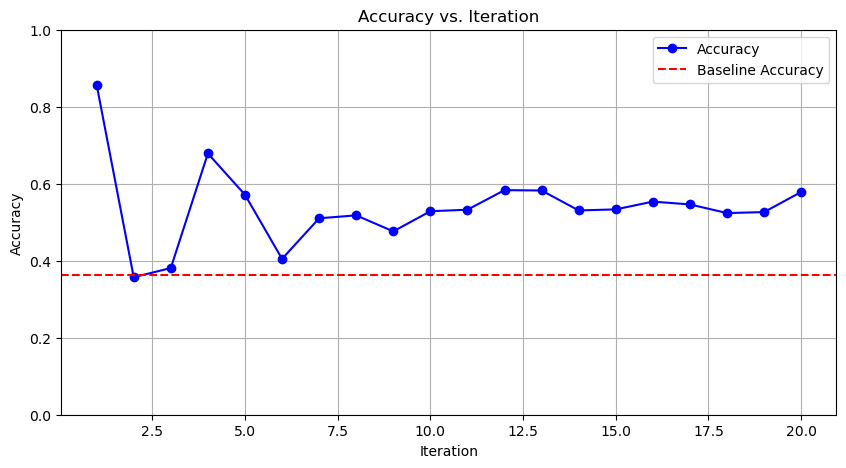

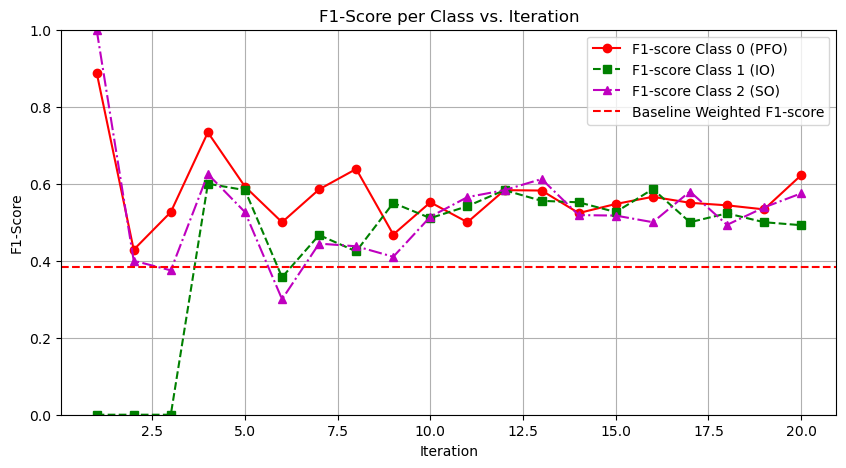

In [158]:
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Gather all classification reports
iterations = 20
classification_reports = [globals()[f'iter{i}'] for i in range(1, iterations+1)]

# Step 2: Extract metrics
accuracy_list = []
f1_score_0 = []
f1_score_1 = []
f1_score_2 = []

for report in classification_reports:
    accuracy_list.append(report['accuracy'])
    f1_score_0.append(report['0']['f1-score'])
    f1_score_1.append(report['1']['f1-score'])
    f1_score_2.append(report['2']['f1-score'])

iterations = np.arange(1, 21)

# Step 3: Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(iterations, accuracy_list, marker='o', linestyle='-', color='b', label='Accuracy')
plt.axhline(y=0.3632, color='r', linestyle='--', label='Baseline Accuracy')
plt.xlabel('Iteration')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Iteration')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()

# Step 4: Plot F1 scores per class
plt.figure(figsize=(10, 5))
plt.plot(iterations, f1_score_0, marker='o', linestyle='-', color='r', label='F1-score Class 0 (PFO)')
plt.plot(iterations, f1_score_1, marker='s', linestyle='--', color='g', label='F1-score Class 1 (IO)')
plt.plot(iterations, f1_score_2, marker='^', linestyle='-.', color='m', label='F1-score Class 2 (SO)')
plt.axhline(y=0.3830, color='r', linestyle='--', label='Baseline Weighted F1-score')
plt.xlabel('Iteration')
plt.ylabel('F1-Score')
plt.title('F1-Score per Class vs. Iteration')
plt.ylim(0, 1)
plt.legend()
plt.grid()
plt.show()


Precision recall curve and threshold selection

In [159]:
#Troubleshooting
print(f"y_true_bin shape: {y_true_bin.shape}")
print(f"y_score shape: {y_score.shape}")

NameError: name 'y_true_bin' is not defined

In [157]:
y_pred_proba = pipeline.predict_proba(X_train)

In [158]:
print(f"y_pred_proba shape: {y_pred_proba.shape}")
print(f"y_train shape: {y_train.shape}")

y_pred_proba shape: (140, 3)
y_train shape: (140,)



--- Class 0 ---
Threshold @ Recall ≥ 0.70: 0.0007
  Recall: 1.00, Precision: 0.51


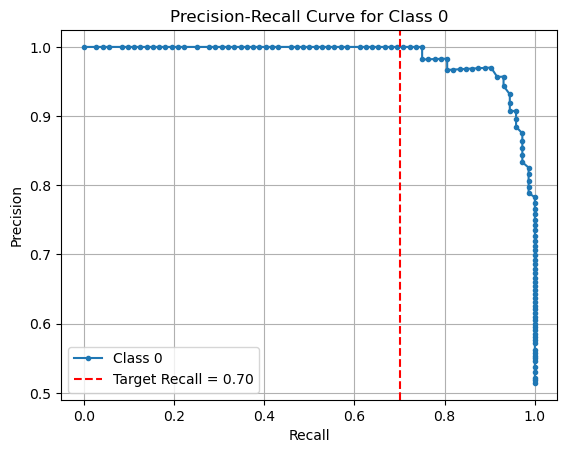


--- Class 1 ---
Threshold @ Recall ≥ 0.70: 0.0023
  Recall: 1.00, Precision: 0.22


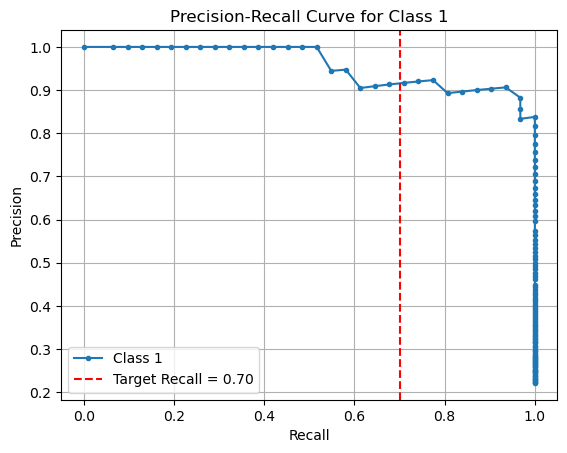


--- Class 2 ---
Threshold @ Recall ≥ 0.70: 0.0079
  Recall: 1.00, Precision: 0.26


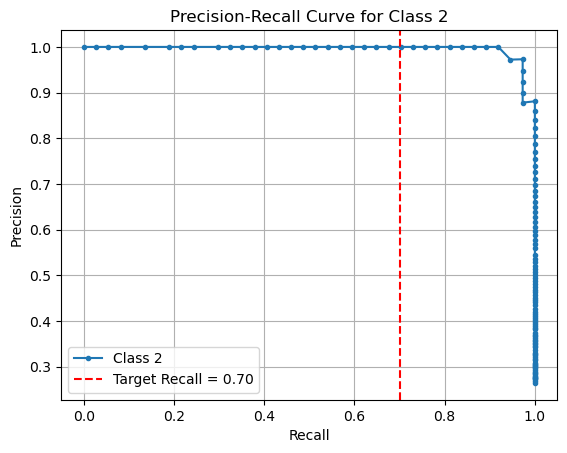


Selected thresholds per class:
Class 0: 0.0006529892166536199
Class 1: 0.00232904367901717
Class 2: 0.007913112875140004


In [160]:
from sklearn.metrics import precision_recall_curve

# Target recall threshold
desired_recall = 0.70
selected_thresholds = {}

# For each class (assuming classes 0, 1, 2)
classes = [0, 1, 2]

for cls in classes:
    print(f"\n--- Class {cls} ---")
    
    # Binary ground truth: 1 if current class, 0 otherwise
    y_true_bin = (y_train == cls).astype(int)
    
    # Predicted probability scores for the current class
    y_score = y_pred_proba[:, cls]
    
    # Compute precision-recall pairs
    precision, recall, thresholds = precision_recall_curve(y_true_bin, y_score)
    
    # precision_recall_curve gives (n_thresholds + 1) recall/precision points
    # thresholds has shape (n_thresholds,)
    
    # Find index where recall crosses desired_recall
    try:
        index = np.where(recall >= desired_recall)[0][0]
        
        if index >= len(thresholds):
            # Edge case: the last recall value doesn't have a corresponding threshold
            selected_threshold = thresholds[-1]
        else:
            selected_threshold = thresholds[index]
        
        selected_thresholds[cls] = selected_threshold
        print(f"Threshold @ Recall ≥ {desired_recall:.2f}: {selected_threshold:.4f}")
        print(f"  Recall: {recall[index]:.2f}, Precision: {precision[index]:.2f}")
        
    except IndexError:
        print(f"No threshold found for class {cls} reaching recall ≥ {desired_recall}")
        selected_thresholds[cls] = None
    
    # Plot the Precision-Recall curve
    plt.figure()
    plt.plot(recall, precision, marker='.', label=f'Class {cls}')
    plt.axvline(x=desired_recall, color='red', linestyle='--', label=f'Target Recall = {desired_recall:.2f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title(f'Precision-Recall Curve for Class {cls}')
    plt.legend()
    plt.grid(True)
    plt.show()

print("\nSelected thresholds per class:")
for cls, thresh in selected_thresholds.items():
    print(f"Class {cls}: {thresh}")


Biasing CNB for class 2

In [161]:
threshold_class_2 = selected_thresholds[2]

# New adjusted predictions
adjusted_preds = []

for prob in y_pred_proba:
    if prob[2] >= threshold_class_2:
        adjusted_preds.append(2)  # Force predict class 2
    else:
        adjusted_preds.append(np.argmax(prob))  # Otherwise, normal prediction

adjusted_preds = np.array(adjusted_preds)


In [ ]:
print(classification_report(y_train, adjusted_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        72
           1       0.00      0.00      0.00        31
           2       0.26      1.00      0.42        37

    accuracy                           0.26       140
   macro avg       0.09      0.33      0.14       140
weighted avg       0.07      0.26      0.11       140



c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\s2421127\AppData\Local\miniconda3\envs\clustering_endpoints\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to cont

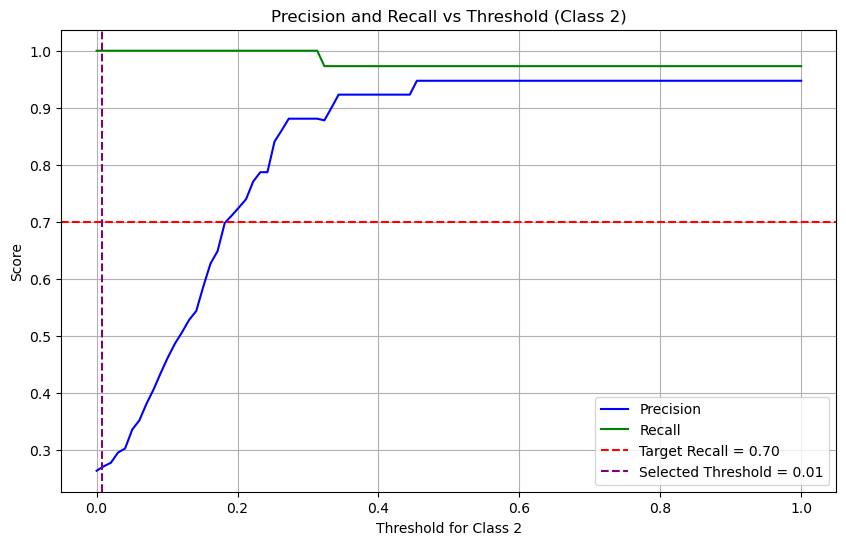

In [163]:
# Plotting Precision and Recall vs Threshold for Class 2
thresholds = np.linspace(0, 1, 100)

# Store precision and recall at each threshold
precisions = []
recalls = []

for thresh in thresholds:
    adjusted_preds = []
    
    for prob in y_pred_proba:
        if prob[2] >= thresh:
            adjusted_preds.append(2)
        else:
            adjusted_preds.append(np.argmax(prob))
    
    adjusted_preds = np.array(adjusted_preds)
    
    # Precision and recall class 2
    precision = precision_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    recall = recall_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    
    precisions.append(precision)
    recalls.append(recall)

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precisions, label='Precision', color='blue')
plt.plot(thresholds, recalls, label='Recall', color='green')
plt.axhline(0.7, color='red', linestyle='--', label='Target Recall = 0.70')
plt.axvline(threshold_class_2, color='purple', linestyle='--', label=f'Selected Threshold = {threshold_class_2:.2f}')
plt.xlabel('Threshold for Class 2')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold (Class 2)')
plt.legend()
plt.grid(True)
plt.show()


In [172]:
thresholds = np.linspace(0, 1, 500)

best_f1 = 0
best_threshold = 0
best_precision = 0
best_recall = 0

for thresh in thresholds:
    adjusted_preds = []
    
    for prob in y_pred_proba:
        if prob[2] >= thresh:
            adjusted_preds.append(2)
        else:
            adjusted_preds.append(np.argmax(prob))
    
    adjusted_preds = np.array(adjusted_preds)
    
    # Calculate precision, recall, f1 for class 2 only
    precision = precision_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    recall = recall_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    f1 = f1_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = thresh
        best_precision = precision
        best_recall = recall

print(f"Best threshold for Class 2 = {best_threshold:.4f}")
print(f"  F1-score = {best_f1:.4f}")
print(f"  Precision = {best_precision:.4f}")
print(f"  Recall = {best_recall:.4f}")

Best threshold for Class 2 = 0.4509
  F1-score = 0.9600
  Precision = 0.9474
  Recall = 0.9730


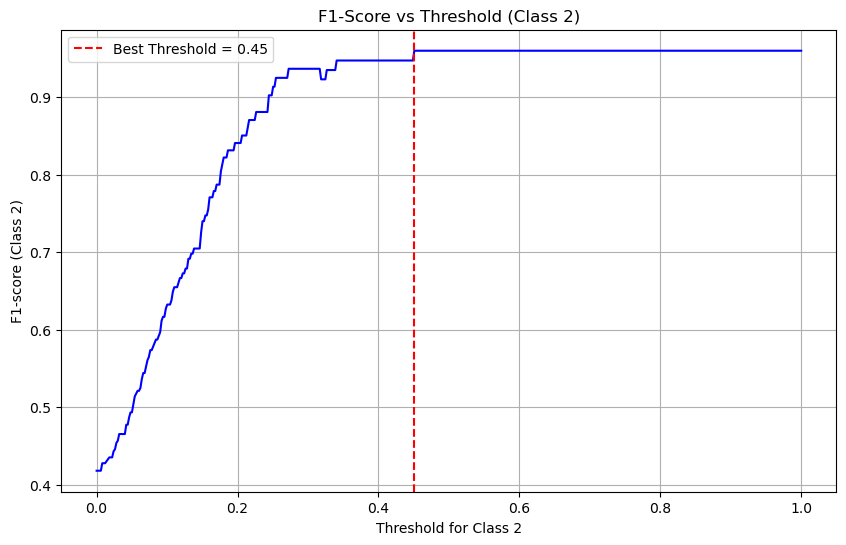

In [173]:
f1_scores = []

for thresh in thresholds:
    adjusted_preds = []
    
    for prob in y_pred_proba:
        if prob[2] >= thresh:
            adjusted_preds.append(2)
        else:
            adjusted_preds.append(np.argmax(prob))
    
    adjusted_preds = np.array(adjusted_preds)
    
    f1 = f1_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    f1_scores.append(f1)

# Plot F1 vs Threshold
plt.figure(figsize=(10,6))
plt.plot(thresholds, f1_scores, color='blue')
plt.axvline(best_threshold, color='red', linestyle='--', label=f'Best Threshold = {best_threshold:.2f}')
plt.xlabel('Threshold for Class 2')
plt.ylabel('F1-score (Class 2)')
plt.title('F1-Score vs Threshold (Class 2)')
plt.grid(True)
plt.legend()
plt.show()

In [174]:
desired_recall = 0.7  
thresholds = np.linspace(0, 1, 500)

# To store candidates
valid_thresholds = []
valid_precisions = []
valid_recalls = []
valid_f1s = []

for thresh in thresholds:
    adjusted_preds = []
    
    for prob in y_pred_proba:
        if prob[2] >= thresh:
            adjusted_preds.append(2)
        else:
            adjusted_preds.append(np.argmax(prob))
    
    adjusted_preds = np.array(adjusted_preds)
    
    # Evaluate class 2 only
    precision = precision_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    recall = recall_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    f1 = f1_score(y_train, adjusted_preds, labels=[2], average='micro', zero_division=0)
    
    # Only accept thresholds meeting the recall constraint
    if recall >= desired_recall:
        valid_thresholds.append(thresh)
        valid_precisions.append(precision)
        valid_recalls.append(recall)
        valid_f1s.append(f1)

# Select best precision among valid thresholds
if valid_thresholds:
    best_idx = np.argmax(valid_precisions)
    best_threshold = valid_thresholds[best_idx]
    best_precision = valid_precisions[best_idx]
    best_recall = valid_recalls[best_idx]
    best_f1 = valid_f1s[best_idx]
    
    print(f"Best threshold (recall ≥ {desired_recall}): {best_threshold:.4f}")
    print(f"  Precision: {best_precision:.4f}")
    print(f"  Recall: {best_recall:.4f}")
    print(f"  F1-score: {best_f1:.4f}")
else:
    print(f"No threshold found achieving recall ≥ {desired_recall}.")


Best threshold (recall ≥ 0.7): 0.4509
  Precision: 0.9474
  Recall: 0.9730
  F1-score: 0.9600


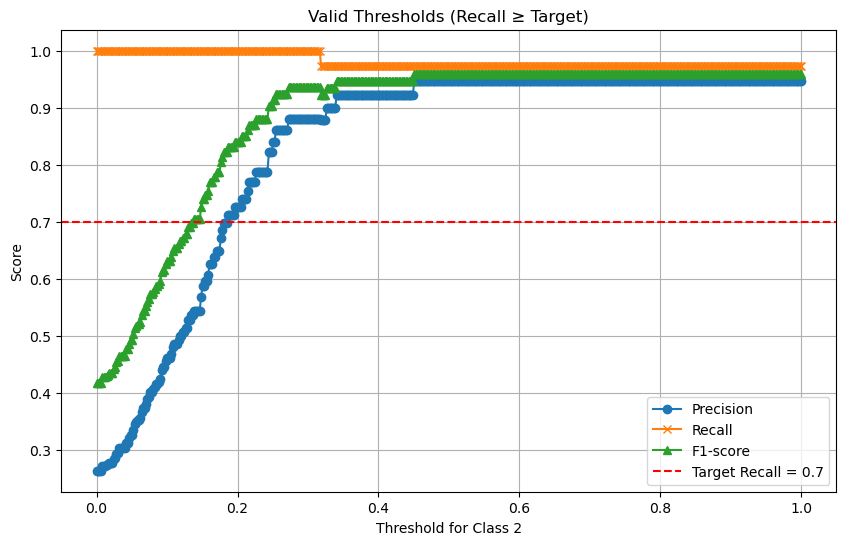

In [175]:
if valid_thresholds:
    plt.figure(figsize=(10,6))
    plt.plot(valid_thresholds, valid_precisions, marker='o', label='Precision')
    plt.plot(valid_thresholds, valid_recalls, marker='x', label='Recall')
    plt.plot(valid_thresholds, valid_f1s, marker='^', label='F1-score')
    plt.axhline(desired_recall, color='red', linestyle='--', label=f'Target Recall = {desired_recall}')
    plt.xlabel('Threshold for Class 2')
    plt.ylabel('Score')
    plt.title('Valid Thresholds (Recall ≥ Target)')
    plt.legend()
    plt.grid(True)
    plt.show()


Sensitivity Analysis
# Would Recall improve if I changed my AL approach? Labelling 1 case over 140 iterations 

Monte Carlo Simulation

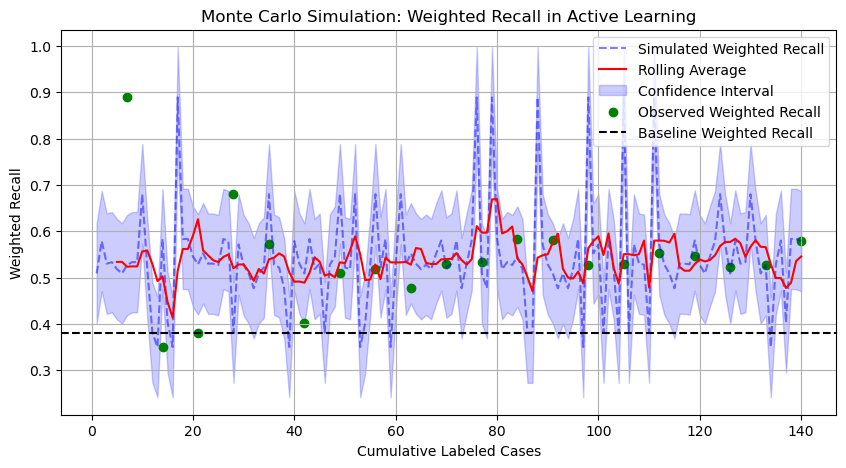

In [ ]:
# This is what I initially did but it was not correct

# Given observed weighted recall (one per active learning iteration, 7 cases each)
weighted_recalls = [0.8889, 0.3500, 0.3810, 0.6800, 0.5714, 0.4028, 0.5089, 0.5182, 
                    0.4769, 0.5286, 0.5333, 0.5833, 0.5800, 0.5278, 0.5300, 0.5523, 
                    0.5455, 0.5218, 0.5269, 0.5786]

# You forgot to include the the rest of the unlabelled dataset in the code. 

# Convert iterations into cumulative labeled cases (7 cases per iteration)
cumulative_labeled_cases = [i * 7 for i in range(1, len(weighted_recalls) + 1)]  # [7, 14, ..., 140]

# Monte Carlo simulation setup
np.random.seed(42)
n_iterations = 140
simulated_weighted_recall = []

for i in range(n_iterations):
    weighted_recall = np.random.choice(weighted_recalls)  # Randomly sample from observed recalls
    simulated_weighted_recall.append(weighted_recall)

# Compute rolling average (window size = 5)
window_size = 5
rolling_avg = np.convolve(simulated_weighted_recall, np.ones(window_size)/window_size, mode='valid')
std_dev = np.std(simulated_weighted_recall)

# Plot results
plt.figure(figsize=(10, 5))
iterations = np.arange(1, n_iterations + 1)
plt.plot(iterations, simulated_weighted_recall, label='Simulated Weighted Recall', linestyle='dashed', color='blue', alpha=0.5)
plt.plot(iterations[window_size-1:], rolling_avg, label='Rolling Average', color='red')
plt.fill_between(iterations, 
                 np.array(simulated_weighted_recall) - std_dev, 
                 np.array(simulated_weighted_recall) + std_dev, 
                 color='blue', alpha=0.2, label='Confidence Interval')

# Plot observed recalls at correct labeled case positions
plt.scatter(cumulative_labeled_cases, weighted_recalls, color='green', label='Observed Weighted Recall')

# Baseline weighted recall
plt.axhline(y=0.3798, color='black', linestyle='--', label='Baseline Weighted Recall')

plt.xlabel('Cumulative Labeled Cases')
plt.ylabel('Weighted Recall')
plt.title('Monte Carlo Simulation: Weighted Recall in Active Learning')
plt.legend()
plt.grid(True)
plt.show()

In [164]:
iterations = 20
classification_reports = [globals()[f'iter{i}'] for i in range(1, iterations+1)]

# Step 1: Extract metrics
accuracy_list = []
f1_score_0 = []
f1_score_1 = []
f1_score_2 = []

for report in classification_reports:
    accuracy_list.append(report['accuracy'])
    f1_score_0.append(report['0']['f1-score'])
    f1_score_1.append(report['1']['f1-score'])
    f1_score_2.append(report['2']['f1-score'])

iterations = np.arange(1, 21)

# Step 2: Convert iterations into cumulative labeled cases (7 cases per iteration)
cases_per_iter = 7
per_case_acc  = np.repeat(accuracy_list, cases_per_iter)
per_case_f1_0 = np.repeat(f1_score_0,    cases_per_iter)
per_case_f1_1 = np.repeat(f1_score_1,    cases_per_iter)
per_case_f1_2 = np.repeat(f1_score_2,    cases_per_iter)

n_cases = per_case_acc.size
n_sims  = 1000
rng     = np.random.default_rng(42)

# 3) Monte Carlo: simulate random labelling orders
# Allocate arrays to store cumulative averages
sim_acc_cum  = np.zeros((n_sims, n_cases))
sim_f1_0_cum = np.zeros((n_sims, n_cases))
sim_f1_1_cum = np.zeros((n_sims, n_cases))
sim_f1_2_cum = np.zeros((n_sims, n_cases))

for sim in range(n_sims):
    perm = rng.permutation(n_cases)
    
    # permuted per-case values
    acc_path  = per_case_acc[perm]
    f1_0_path = per_case_f1_0[perm]
    f1_1_path = per_case_f1_1[perm]
    f1_2_path = per_case_f1_2[perm]
    
    # cumulative mean at each labeling step
    cum_steps = np.arange(1, n_cases + 1)
    sim_acc_cum[sim]  = np.cumsum(acc_path)  / cum_steps
    sim_f1_0_cum[sim] = np.cumsum(f1_0_path) / cum_steps
    sim_f1_1_cum[sim] = np.cumsum(f1_1_path) / cum_steps
    sim_f1_2_cum[sim] = np.cumsum(f1_2_path) / cum_steps

# 4) Summary of results 
mean_acc   = sim_acc_cum.mean(axis=0)
ci_acc_lo  = np.percentile(sim_acc_cum, 2.5, axis=0)
ci_acc_hi  = np.percentile(sim_acc_cum, 97.5, axis=0)

mean_f1_0  = sim_f1_0_cum.mean(axis=0)
ci_f1_0_lo = np.percentile(sim_f1_0_cum, 2.5, axis=0)
ci_f1_0_hi = np.percentile(sim_f1_0_cum,97.5, axis=0)

mean_f1_1  = sim_f1_1_cum.mean(axis=0)
ci_f1_1_lo = np.percentile(sim_f1_1_cum, 2.5, axis=0)
ci_f1_1_hi = np.percentile(sim_f1_1_cum,97.5, axis=0)

mean_f1_2  = sim_f1_2_cum.mean(axis=0)
ci_f1_2_lo = np.percentile(sim_f1_2_cum, 2.5, axis=0)
ci_f1_2_hi = np.percentile(sim_f1_2_cum,97.5, axis=0)

# 5) Print example summary points
print("Cumulative learning curve summary (mean ± 95% CI):")
for t in [1, 7, 50, 140]:
    idx = t - 1
    print(f"\nAfter {t} cases:")
    print(f"  Accuracy = {mean_acc[idx]:.3f} ({ci_acc_lo[idx]:.3f}, {ci_acc_hi[idx]:.3f})")
    print(f"  F1-class0 = {mean_f1_0[idx]:.3f} ({ci_f1_0_lo[idx]:.3f}, {ci_f1_0_hi[idx]:.3f})")
    print(f"  F1-class1 = {mean_f1_1[idx]:.3f} ({ci_f1_1_lo[idx]:.3f}, {ci_f1_1_hi[idx]:.3f})")
    print(f"  F1-class2 = {mean_f1_2[idx]:.3f} ({ci_f1_2_lo[idx]:.3f}, {ci_f1_2_hi[idx]:.3f})")

Cumulative learning curve summary (mean ± 95% CI):

After 1 cases:
  Accuracy = 0.539 (0.357, 0.857)
  F1-class0 = 0.572 (0.429, 0.889)
  F1-class1 = 0.444 (0.000, 0.600)
  F1-class2 = 0.527 (0.300, 1.000)

After 7 cases:
  Accuracy = 0.539 (0.472, 0.613)
  F1-class0 = 0.572 (0.517, 0.645)
  F1-class1 = 0.445 (0.291, 0.549)
  F1-class2 = 0.526 (0.442, 0.640)

After 50 cases:
  Accuracy = 0.539 (0.515, 0.562)
  F1-class0 = 0.574 (0.551, 0.595)
  F1-class1 = 0.443 (0.398, 0.483)
  F1-class2 = 0.526 (0.495, 0.557)

After 140 cases:
  Accuracy = 0.539 (0.539, 0.539)
  F1-class0 = 0.573 (0.573, 0.573)
  F1-class1 = 0.443 (0.443, 0.443)
  F1-class2 = 0.526 (0.526, 0.526)


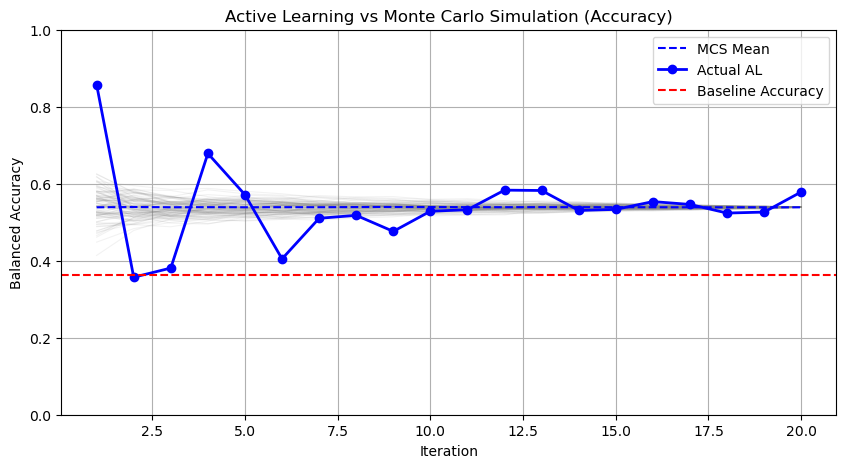

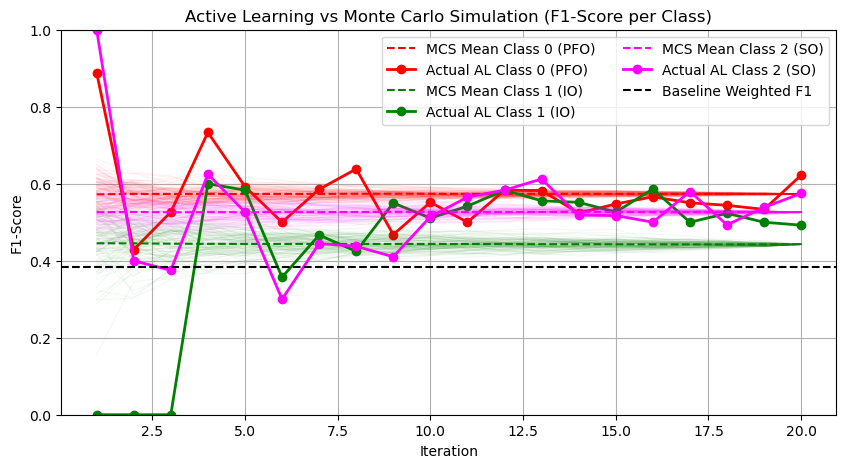

In [ ]:
# Parameters
iterations = 20
cases_per_iter = 7
n_cases = sim_acc_cum.shape[1]

# X-axis: iteration numbers 
iter_x = np.arange(1, iterations+1)

# Which columns of sim_* to sample at each iteration?
iter_idxs = iter_x * cases_per_iter - 1

# How many simulation paths to draw for the spaghetti?
n_spaghetti = min(100, sim_acc_cum.shape[0])
rng = np.random.default_rng(42)
spaghetti_idx = rng.choice(sim_acc_cum.shape[0], size=n_spaghetti, replace=False)

# Accuracy Plot
plt.figure(figsize=(10, 5))

for sim in spaghetti_idx:
    plt.plot(iter_x,
             sim_acc_cum[sim, iter_idxs],
             color='grey', alpha=0.1, linewidth=0.8)

mean_acc_iter = sim_acc_cum[:, iter_idxs].mean(axis=0)
plt.plot(iter_x, mean_acc_iter,
         color='blue', linestyle='--',
         label='MCS Mean')

plt.plot(iter_x, accuracy_list,
         marker='o', color='blue', linewidth=2,
         label='Actual AL')

plt.axhline(y=0.3632, color='red', linestyle='--', label='Baseline Accuracy')

plt.xlabel('Iteration')
plt.ylabel('Balanced Accuracy')
plt.title('Active Learning vs Monte Carlo Simulation (Accuracy)')
plt.ylim(0,1)
plt.legend()
plt.grid(True)
plt.show()


# F1 score per class plot
plt.figure(figsize=(10, 5))

colors = ['red','green','magenta']
labels = ['Class 0 (PFO)','Class 1 (IO)','Class 2 (SO)']
sim_cum_f1 = [sim_f1_0_cum, sim_f1_1_cum, sim_f1_2_cum]
actual_f1  = [f1_score_0, f1_score_1, f1_score_2]

for cls in range(3):
    for sim in spaghetti_idx:
        plt.plot(iter_x,
                 sim_cum_f1[cls][sim, iter_idxs],
                 color=colors[cls], alpha=0.05, linewidth=0.8)

    mean_f1_iter = sim_cum_f1[cls][:, iter_idxs].mean(axis=0)
    plt.plot(iter_x, mean_f1_iter,
             color=colors[cls], linestyle='--',
             label=f'MCS Mean {labels[cls]}')
    
    plt.plot(iter_x, actual_f1[cls],
             marker='o', color=colors[cls], linewidth=2,
             label=f'Actual AL {labels[cls]}')


plt.axhline(y=0.3830, color='black', linestyle='--', label='Baseline Weighted F1')

plt.xlabel('Iteration')
plt.ylabel('F1-Score')
plt.title('Active Learning vs Monte Carlo Simulation (F1-Score per Class)')
plt.ylim(0,1)
plt.legend(ncol=2)
plt.grid(True)
plt.show()


Apply hyperparameter tuned CNB to EUCT-NS
# The whole of the EUCT-NS dataset is labelled so I will be able to draw a conclusion on how well this classifier 'works'.